## Phase of meta atom:

The notebook reproduces the phase of meta atom (Figure 1) in [Arbabi, Amir, et al,Scientific reports,2020](https://link.springer.com/content/pdf/10.1038/s41598-020-64198-8.pdf)

<img src="./Images/Si_atom.png" width="200" height="200" align="left">


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import sys
path_parent=os.path.dirname(os.getcwd())
sys.path.insert(0,path_parent)
from src import Scattering
from src import Plot
from src import Computation
from src import Geo

## Optical index

In [2]:
wavelength_range=np.array([915])
n_Si=3.65
e_Si=np.array([np.conj(n_Si**2)])
e_SiO2=1.45**2 
#reflectance and transmission
u_ref=1; u_trn=1;  e_ref=1; e_trn=np.copy(e_SiO2);  e_air=1

## Input parameters

In [3]:
#Angle
AOI_d = 0
Azimuth_d=0
AOI_r=np.radians(AOI_d) 
Azimuth_r=np.radians(Azimuth_d) 

#geometry
Lx_cell=400; Ly_cell=400  #pitch in nm
reso=1
Thickness_Sim=[500] # only one layer

# diffraction order in x-y direction
mx=5;my=5     

## Parameters in RCWA

In [4]:
NL=len(Thickness_Sim)
#Geometry
Geo.reso, Geo.Lx_cell, Geo.Ly_cell= reso, Lx_cell, Ly_cell
Geo.mx, Geo.my= mx, my
Geo.edge_sharpness=500

#Scattering
Scattering.AOI_r, Scattering.Azimuth_r =AOI_r, Azimuth_r
# important
Scattering.Meshgrid()
Scattering.Angles()

In [5]:
# Sweep 
W_range=np.linspace(60,260,201)

In [6]:
#layer materials
Geometry=[]
for W_th in W_range:
    layer_lth={} 
    layer_lth['Shape']=Geo.Rectangle
    layer_lth['e_base']=1
    layer_lth['e_grt']=e_Si
    layer_lth['Critical']=[W_th,W_th]
    layer_lth['Center']=[Lx_cell/2,Ly_cell/2]
    
    Geometry.append(layer_lth)  

## Visualization

/home/pham/Desktop/ScatteringM_Github/src/NanoStructure.py:18: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-x))


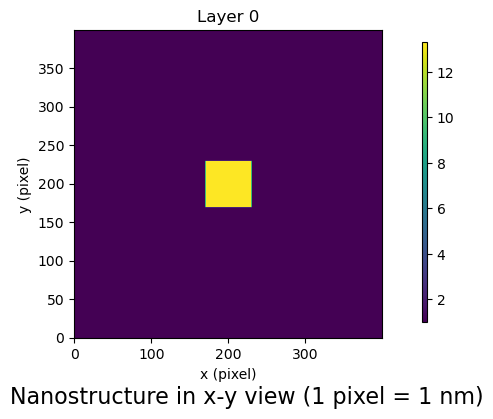

In [7]:
geo_e=np.array([Plot.Geo_viz(layer_lth) for layer_lth in Geometry])
Plot.Viz_xy(geo_e,pos_layer=[0])

# Simulation

In [8]:
t0=time.time()
ERC_CONV=[Geo.CONV_layer(wavelength_range,layer_lth) for layer_lth in Geometry]
t_conv=time.time()-t0
print(t_conv)

3.1958441734313965


In [9]:
t0=time.time()
Trn=[]
T_x=[]
T_y=[]  
unit_mat=Scattering.unit_mat

Scattering.KxKy_Component(wavelength_range[0],e_ref,e_trn)   

for lth in  range(len(W_range)):   
    # S-layer        
    S11,S21=Scattering.S_Layer(Thickness_Sim[0],ERC_CONV[lth][0])      
    
    S_trn=Scattering.Trn_medium()     
    
    S_global_11,_,S_global_21,_=Computation.redheffer_global(unit_mat,[S11,S21,S21,S11],S_trn)  # only one layer
                  
    tx,ty= Scattering.Optical_Response(S_global_21,'pte')   
    #rx,ry= Scattering.Optical_Response(S_global_11,'pte') 
    T_x.append(tx)
    T_y.append(ty)    
    
    T=Scattering.Transmittance(tx,ty)     
    Trn.append(np.sum(T))  


Trn=np.array(Trn) 
#Ref=np.array(Ref)

T_x=np.array(T_x); T_y=np.array(T_y)

print(time.time() -t0)    

18.388448238372803


In [10]:
order=Scattering.Nharm//2
phase=np.unwrap(-np.angle(T_y[:,order,0]))/2/np.pi

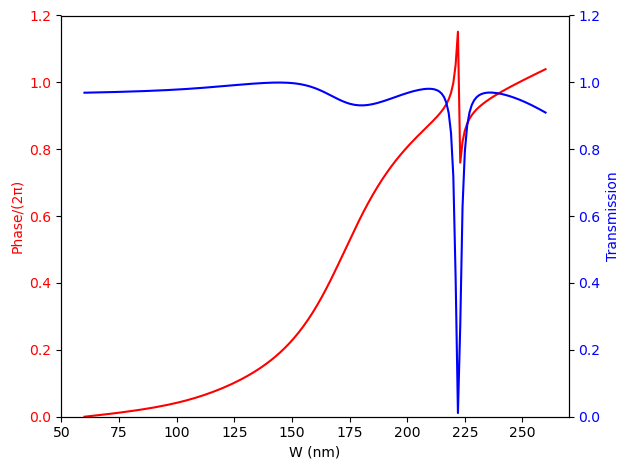

In [11]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('W (nm)')
ax1.set_ylabel('Phase/(2π)', c='r')
ax1.plot(W_range, phase-phase.min(),c='r')
ax1.tick_params(axis='y', labelcolor='r')
ax1.set_ylim([0,1.2])

ax2 = ax1.twinx() 
ax2.set_ylabel('Transmission', c='blue')
ax2.plot(W_range, Trn,c='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim([0,1.2])
fig.tight_layout() 
plt.show()